In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import datetime as dt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('ggplot')

## Import the cleaned data set

In [2]:
df = pd.read_csv("cleaned_CA_data.csv")

In [3]:
df = df.drop(columns=['Unnamed: 0'])

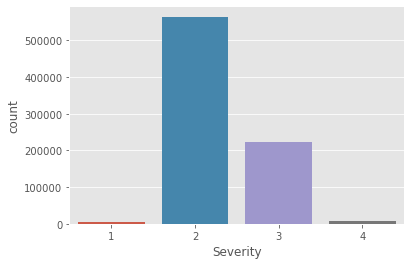

In [4]:
sns.countplot(x="Severity", data=df)

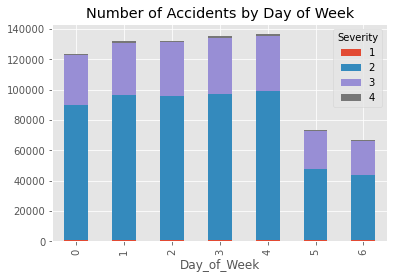

In [5]:
df.groupby(['Day_of_Week','Severity']).size().unstack().plot(kind='bar',stacked=True, title="Number of Accidents by Day of Week")
plt.show()

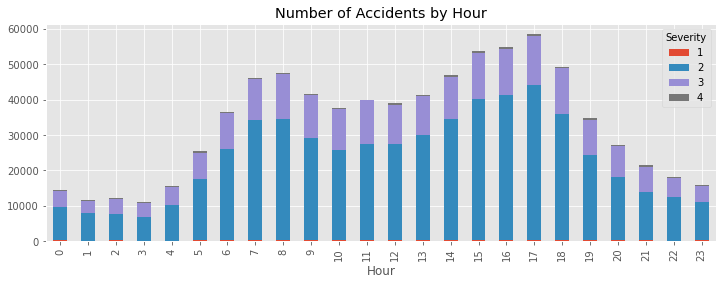

In [6]:
df.groupby(['Hour','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4), title="Number of Accidents by Hour")
plt.show()

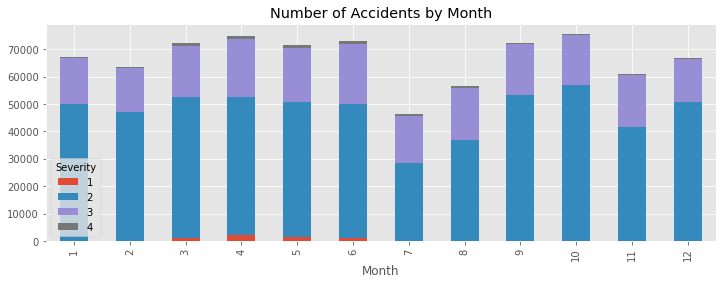

In [7]:
df.groupby(['Month','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4), title="Number of Accidents by Month")
plt.show()

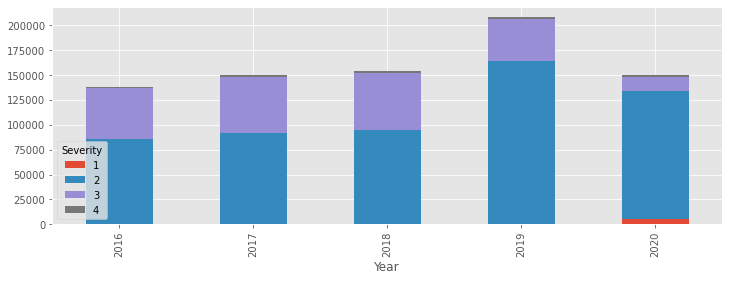

In [8]:
df.groupby(['Year','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4))
plt.show()

In [9]:
#plot Severity distribution and print count for each
# df['County'].plot(kind="hist")
county_ct = dict()
for i in df['County'].unique():
#     print('County', i, df[df['County'] == i]['Severity'].count())
    county_ct[i] = df[df['County'] == i]['Severity'].count()

sorted_x = sorted(county_ct.items(), key=lambda kv: kv[1])
sorted_x

'''
Top ounties with the most accident records:
1. LA
2. Alameda
3. Orange
4. San Diego
5. San Bernardino
6. Sacramento
7. Riverside
8. Santa Clara
9. Contra Costa
10. San Mateo
'''

'\nTop ounties with the most accident records:\n1. LA\n2. Alameda\n3. Orange\n4. San Diego\n5. San Bernardino\n6. Sacramento\n7. Riverside\n8. Santa Clara\n9. Contra Costa\n10. San Mateo\n'

### Let's run a Decision Tree Classifier just to see what the results look like:
- Accuracy: 0.858
- What does this mean? Over 560k of the 800k are Severity == 2...

In [10]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462, stratify=y)

In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, pred)))

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

Accuracy = 0.847
F1 score: 0.8475048325643788
Recall score: 0.846687022442993
My prediction: [3 4 2 2 2 2 3 3 2 2 2 3 2 2 2 2 2 2 2 3]
Actual result: [3 2 2 2 2 2 3 3 2 2 2 3 2 2 2 2 2 2 2 2]


In [13]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

# Accuracy score
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

accuracy = 0.8515144397747205
F1 score: 0.8460920904290222
Recall score: 0.8515144397747205


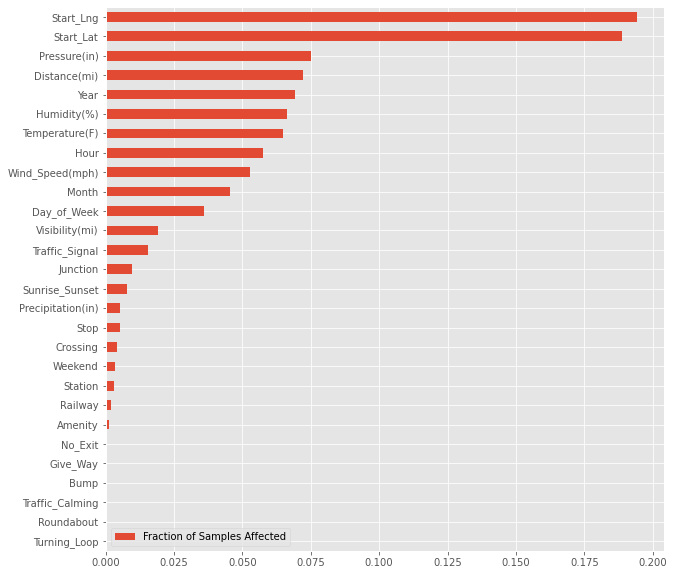

In [14]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,10))

## Turn `Weather_Condition` and `Severity` into binary features
- Separate Weather Conditions into "good" and "bad"
    - Maybe break it down further? "Good", "Mild", and "Bad"?

In [15]:
pd.set_option('display.max_rows', None)
df.groupby('Weather_Condition').count()

Severity  Start_Lat  Start_Lng  Distance(mi)  \
Weather_Condition                                                            
Blowing Dust                        56         56         56            56   
Blowing Dust / Windy                56         56         56            56   
Blowing Sand                         1          1          1             1   
Clear                           253069     253069     253069        253069   
Cloudy                           46052      46052      46052         46052   
Cloudy / Windy                     230        230        230           230   
Drizzle                            313        313        313           313   
Drizzle / Windy                      1          1          1             1   
Dust Whirls                          1          1          1             1   
Fair                            179149     179149     179149        179149   
Fair / Windy                      2547       2547       2547          2547   
Fog                               6260       6260       6260          6260   
Fog / Windy                         17         17         17            17   
Hail                                 2          2          2             2   
Haze                             25202      25202      25202         25202   
Haze / Windy                        37         37         37            37   
Heavy Drizzle                       35         35         35            35   
Heavy Rain                        3236       3236       3236          3236   
Heavy Rain / Windy                  64         64         64            64   
Heavy Rain Shower                    2          2          2             2   
Heavy Smoke                          1          1          1             1   
Heavy Snow                         103        103        103           103   
Heavy T-Storm                       42         42         42            42   
Heavy Thunderstorms and Rain        21         21         21            21   
Light Drizzle                      399        399        399           399   
Light Drizzle / Windy                1          1          1             1   
Light Freezing Fog                  22         22         22            22   
Light Freezing Rain                  3          3          3             3   
Light Hail                           2          2          2             2   
Light Haze                           6          6          6             6   
Light Rain                       28386      28386      28386         28386   
Light Rain / Windy                 211        211        211           211   
Light Rain Shower                   62         62         62            62   
Light Rain Shower / Windy           10         10         10            10   
Light Rain Showers                  29         29         29            29   
Light Rain with Thunder             46         46         46            46   
Light Snow                         496        496        496           496   
Light Snow / Windy                   9          9          9             9   
Light Snow Showers                   1          1          1             1   
Light Thunderstorm                   1          1          1             1   
Light Thunderstorms and Rain        59         59         59            59   
Mist                               396        396        396           396   
Mostly Cloudy                    77761      77761      77761         77761   
Mostly Cloudy / Windy              445        445        445           445   
N/A Precipitation                   16         16         16            16   
Overcast                         58471      58471      58471         58471   
Partial Fog                         13         13         13            13   
Partly Cloudy                    74323      74323      74323         74323   
Partly Cloudy / Windy              578        578        578           578   
Patches of Fog                     246        246   

In [16]:
len(set(df['Weather_Condition']))

72

In [17]:
weather_vals = df['Weather_Condition'].values
good_weather = list(set(['Clear', 'Fair', 'Fair / Windy']))
mild_weather = list(set(['Blowing Dust', 'Partly Cloudy', 'Scattered Clouds', 'Mostly Cloudy',
                'Overcast', 'Mist', 'Smoke', 'Smoke / Windy', 'Shallow Fog', 'Cloudy / Windy', 'Drizzle',
                'Cloudy', 'Mostly Cloudy / Windy', 'N/A Precipitation', 'Partial Fog',
                'Partly Cloudy', 'Partly Cloudy / Windy', 'Patches of Fog', 'Showers in the Vicinity']))
bad_weather = list(set(['Blowing Sand', 'Blowing Dust / Windy', 'Dust Whirls', 'Fog', 'Fog / Windy',
             'Hail', 'Haze', 'Haze / Windy', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Rain / Windy',
             'Heavy Rain Shower', 'Heavy Smoke', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain',
             'Light Drizzle', 'Light Drizzle / Windy', 'Light Freezing Fog', 'Light Freezing Rain',
             'Light Hail', 'Light Haze', 'Light Rain', 'Light Rain / Windy', 'Light Rain Shower',
             'Light Rain Shower / Windy', 'Light Rain Showers', 'Light Rain with Thunder',
             'Light Snow', 'Light Snow / Windy', 'Light Snow Showers', 'Light Thunderstorm',
             'Light Thunderstorms and Rain', 'Drizzle / Windy', 'Rain', 'Rain / Windy', 'Rain Shower',
             'Rain Showers', 'Snow', 'Snow / Windy', 'Squalls', 'Squalls / Windy', 'T-Storm', 'Thunder',
             'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms and Rain', 'Volcanic Ash', 
             'Widespread Dust', 'Widespread Dust / Windy', 'Wintry Mix']))

# bad_weather = list(set([i for i in df['Weather_Condition'].values if i not in good_weather]))

counter_good = 0
counter_mild = 0
counter_bad = 0


for i in df['Weather_Condition'].values:
    if i in good_weather:
        counter_good += 1
    elif i in mild_weather:
        counter_mild += 1
    else:
        counter_bad += 1
        
total_counter = counter_good + counter_mild + counter_bad
        
print('Total # of Weather Conditions:', len(good_weather) +len(mild_weather) + len(bad_weather))
print('Good:', counter_good, ',', round(100*counter_good/total_counter, 2), '% of total')
print('Mild:', counter_mild, ',', round(100*counter_mild/total_counter, 2), '% of total')
print('Bad:', counter_bad, ',', round(100*counter_bad/total_counter, 2), '% of total')

Total # of Weather Conditions: 72
Good: 434765 , 54.32 % of total
Mild: 290434 , 36.28 % of total
Bad: 75228 , 9.4 % of total


### Let's test it out. 
- Switch Weather Condition values to either 0 = "good", 1 = "mild", and 2 = "bad"  

In [18]:
def simplify_vals(col:str, value:list, replacement:list, df=df):
    df[col] = df[col].replace(value, replacement*len(value))

In [19]:
#Replace Weather_Condition values with either 0 (good) or 1 (bad)
simplify_vals(col='Weather_Condition', value=good_weather, replacement=[0])
simplify_vals(col='Weather_Condition', value=mild_weather, replacement=[1])
simplify_vals(col='Weather_Condition', value=bad_weather, replacement=[2])

In [20]:
#Replace Severity values with either 0 (low - 1,2) or 1 (high - 3,4)
# simplify_vals(col='Severity', value=sev12, replacement=[0])
# simplify_vals(col='Severity', value=sev34, replacement=[1])

In [21]:
df['Severity'].unique()

array([3, 2, 1, 4])

In [22]:
df['Weather_Condition'].unique()

array([0, 1, 2])

### Re-run the Decision Tree Classifier and RF Classifier to compare results

In [23]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462, stratify=y)

Accuracy = 0.845
F1 score: 0.8462645856342821
Recall score: 0.8454177015296817
[[[197862    826]
  [   530    889]]

 [[ 44655  14263]
  [ 15576 125613]]

 [[130328  14341]
  [ 13577  41861]]

 [[196543   1503]
  [  1250    811]]]
              precision    recall  f1-score   support

           1     0.5184    0.6265    0.5673      1419
           2     0.8980    0.8897    0.8938    141189
           3     0.7448    0.7551    0.7499     55438
           4     0.3505    0.3935    0.3707      2061

    accuracy                         0.8454    200107
   macro avg     0.6279    0.6662    0.6455    200107
weighted avg     0.8473    0.8454    0.8463    200107



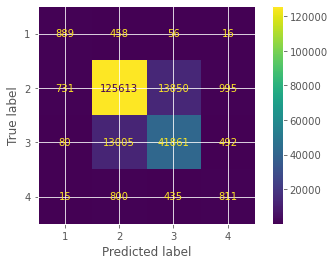

In [24]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, pred)))

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

accuracy = 0.8487009449944279
F1 score: 0.8430490813065353
Recall score: 0.8487009449944279
[[[198390    298]
  [   621    798]]

 [[ 38703  20215]
  [  9617 131572]]

 [[135029   9640]
  [ 18590  36848]]

 [[197923    123]
  [  1448    613]]]
              precision    recall  f1-score   support

           1     0.7281    0.5624    0.6346      1419
           2     0.8668    0.9319    0.8982    141189
           3     0.7926    0.6647    0.7230     55438
           4     0.8329    0.2974    0.4383      2061

    accuracy                         0.8487    200107
   macro avg     0.8051    0.6141    0.6735    200107
weighted avg     0.8449    0.8487    0.8430    200107



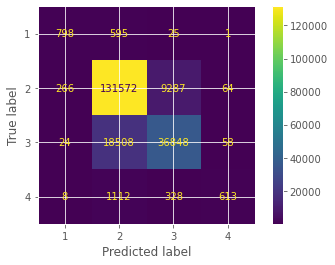

In [25]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                            max_features='auto',
                            n_jobs=-1,
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

# Accuracy
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

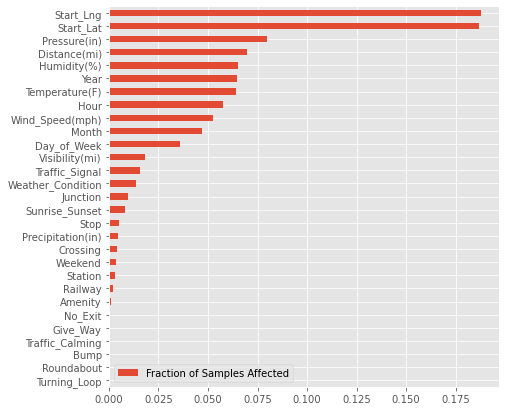

In [26]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(7,7))

## Let's try removing the outliers from the numerical columns to see if our scores improve
- numerical columns = ['Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
- Distance max = 227.21 mi
- Temp max = 127.4 F (this is okay)
- Visibility max = 140 mi
- Wind Speed max = 822.8 mph


In [27]:
pd.set_option('display.max_columns', None)
df.describe()

Severity      Start_Lat      Start_Lng   Distance(mi)  \
count  800427.000000  800427.000000  800427.000000  800427.000000   
mean        2.290555      35.532484    -119.486306       0.110388   
std         0.490828       2.035670       1.952353       0.623116   
min         1.000000      32.542587    -124.369232       0.000000   
25%         2.000000      33.956570    -121.648949       0.000000   
50%         2.000000      34.164516    -118.387817       0.000000   
75%         3.000000      37.698586    -117.916377       0.010000   
max         4.000000      42.005420    -114.300598     227.210007   

       Temperature(F)    Humidity(%)   Pressure(in)  Visibility(mi)  \
count   800427.000000  800427.000000  800427.000000   800427.000000   
mean        64.973985      59.572757      29.794128        9.149454   
std         12.498112      23.429945       0.566702        2.357273   
min        -29.900000       1.000000       0.300000        0.000000   
25%         56.000000      42.000000      29.800000       10.000000   
50%         64.000000      62.000000      29.920000       10.000000   
75%         73.000000      78.000000      30.030000       10.000000   
max        127.400000     100.000000      33.040000      140.000000   

       Wind_Speed(mph)  Precipitation(in)  Weather_Condition        Amenity  \
count    800427.000000      800427.000000      800427.000000  800427.000000   
mean          7.201091           0.002962           0.550819       0.006425   
std           5.399943           0.034612           0.659839       0.079900   
min           0.000000           0.000000           0.000000       0.000000   
25%           4.600000           0.000000           0.000000       0.000000   
50%           7.202019           0.000000           0.000000       0.000000   
75%           9.200000           0.000000           1.000000       0.000000   
max         822.800000          24.000000           2.000000       1.000000   

                Bump       Crossing       Give_Way       Junction  \
count  800427.000000  800427.000000  800427.000000  800427.000000   
mean        0.000216       0.032059       0.000795       0.135300   
std         0.014700       0.176157       0.028177       0.342044   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             No_Exit        Railway     Roundabout        Station  \
count  800427.000000  800427.000000  800427.000000  800427.000000   
mean        0.000422       0.010813       0.000022       0.019392   
std         0.020545       0.103422       0.004742       0.137899   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                Stop  Traffic_Calming  Traffic_Signal  Turning_Loop  \
count  800427.000000    800427.000000   800427.000000      800427.0   
mean        0.017773         0.000292        0.081322           0.0   
std         0.132126         0.017096        0.273329           0.0   
min         0.000000         0.000000        0.000000           0.0   
25%         0.000000         0.000000        0.000000           0.0   
50%         0.000000         0.000000        0.000000           0.0   
75%         0.000000         0.000000        0.000000           0.0   
max         1.000000         1.000000        1.000000           0.0   

       Sunrise_Sunset           Hour    Day_of_Week          Month  \
count   800427.000000  800427.000000  800427.000000  800427.000000   
mean         0

In [28]:
q = df['Visibility(mi)'].quantile(0.99)
#99th_q_dist = 1.62
#99th_q_temp = 97.0
#99th_q_visib = 10.0
#99th_q_windspeed = 21.0

df2 = df[df['Distance(mi)'] < 1.62]
df3 = df2[df2['Visibility(mi)'] < 11.0]
cldf = df3[df3['Wind_Speed(mph)'] < 21.0]
#cldf = cleaned dataset with no outliers

In [54]:
df.groupby('Year')['Severity'].value_counts()

Year  Severity
2016  2            85602
      3            51348
      4             1182
      1               96
2017  2            91464
      3            56870
      4             1562
      1               85
2018  2            95023
      3            57236
      4             1552
      1               39
2019  2           164393
      3            41975
      4             1928
      1               18
2020  2           128274
      3            14323
      1             5436
      4             2021
Name: Severity, dtype: int64

In [55]:
#get rid of 2020 data --> severity 1 is too imbalaced over the time period, most are in 2020
cldf = cldf[cldf['Year'] < 2020]

In [57]:
cldf.groupby('Year')['Severity'].value_counts()
#much more balanced

Year  Severity
2016  2            84260
      3            50734
      4              964
      1               94
2017  2            89343
      3            55816
      4             1291
      1               85
2018  2            93318
      3            56291
      4             1372
      1               39
2019  2           161022
      3            40521
      4             1574
      1               17
Name: Severity, dtype: int64

In [29]:
# cldf.to_csv('final_no_outliers_CA_data.csv')

In [58]:
for i in cldf['Severity'].unique():
    print('Severity', i, 
          cldf[cldf['Severity'] == i]['Start_Lat'].count())

Severity 3 203362
Severity 2 427943
Severity 1 235
Severity 4 5201


## Run Logististic Reg, Decision Tree, and RF Classifiers WITHOUT outliers

In [65]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.4)

In [32]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Accuracy Score:', accuracy_score(y_test, lr_pred))

# Checking unique values
predictions = pd.DataFrame(lr_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, lr_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, lr_pred, average='weighted'))

Accuracy Score: 0.7083233603640692
Prediction value counts: 2    310070
3      3277
Name: 0, dtype: int64
F1 Score: 0.5967290937265983
Recall Score: 0.7083233603640692


In [66]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='weighted'))

print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, clf_pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

Accuracy = 0.852
Prediction value counts: 2    169822
3     82370
4      2392
1       113
Name: 0, dtype: int64
F1 Score: 0.8523561365974006
Recall Score: 0.8517493335217926
              precision    recall  f1-score   support

           1     0.0088    0.0106    0.0097        94
           2     0.8962    0.8891    0.8926    171178
           3     0.7774    0.7872    0.7823     81345
           4     0.2972    0.3418    0.3180      2080

    accuracy                         0.8517    254697
   macro avg     0.4949    0.5072    0.5006    254697
weighted avg     0.8530    0.8517    0.8524    254697

Accuray per class: [0.00884956 0.89616186 0.77744324 0.2972408 ]


In [67]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(confusion_matrix(y_test, pred, labels=[1,2,3,4]))
print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))
print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

accuracy = 0.841796330541781
F1 score: 0.8373010273841851
Recall score: 0.841796330541781
[[     0     72     22      0]
 [     4 157170  13975     29]
 [     0  24597  56708     40]
 [     0   1224    331    525]]
[[[254599      4]
  [    94      0]]

 [[ 57626  25893]
  [ 14008 157170]]

 [[159024  14328]
  [ 24637  56708]]

 [[252548     69]
  [  1555    525]]]
              precision    recall  f1-score   support

           1     0.0088    0.0106    0.0097        94
           2     0.8962    0.8891    0.8926    171178
           3     0.7774    0.7872    0.7823     81345
           4     0.2972    0.3418    0.3180      2080

    accuracy                         0.8517    254697
   macro avg     0.4949    0.5072    0.5006    254697
weighted avg     0.8530    0.8517    0.8524    254697

Accuray per class: [0.         0.85855689 0.79829945 0.88383838]


## Let's generate synthetic samples to balance the dataset based on `Severity`
- imlearn's SMOTE - Synthetic Minority Oversampling Technique

In [68]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.33)

In [69]:
#set up test and train sets first, which we already have
sm = SMOTE(random_state=462) #this leads to 1.1mil rows
# usr = RandomUnderSampler(random_state=462, sampling_strategy='all') #this leads to only 11k rows
print('Original dataset shape %s' % Counter(y_train))
X_train, y_train = sm.fit_sample(X_train, y_train)
# X_train, y_train = usr.fit_resample(X_train, y_train)

# sme = SMOTEENN(random_state=462, sampling_strategy={1: 100000, 2: 100000, 3: 100000, 4: 100000} ,n_jobs=-1)
# X_train, y_train = sme.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({2: 286722, 3: 136252, 4: 3485, 1: 157})
Resampled dataset shape Counter({3: 286722, 2: 286722, 4: 286722, 1: 286722})


My prediction: [2 4 3 2 2 2 2 2 2 2 2 3 2 2 2 3 2 2 3 3]
Actual result: [3 3 3 2 2 2 3 2 3 2 3 3 3 2 2 3 2 2 3 2]
Prediction value counts: 2    134807
3     72796
4      2296
1       226
Name: 0, dtype: int64
Accuracy = 0.812
F1 Score: 0.8151450228922117
Recall Score: 0.812330755502677
[[[209821    226]
  [    78      0]]

 [[ 52956  15948]
  [ 22362 118859]]

 [[121435  21580]
  [ 15894  51216]]

 [[206729   1680]
  [  1100    616]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        78
           2     0.8817    0.8417    0.8612    141221
           3     0.7036    0.7632    0.7321     67110
           4     0.2683    0.3590    0.3071      1716

    accuracy                         0.8123    210125
   macro avg     0.4634    0.4909    0.4751    210125
weighted avg     0.8195    0.8123    0.8151    210125

Accuray per class: [0.         0.88169754 0.70355514 0.26829268]


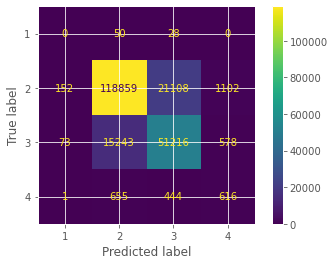

In [70]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("My prediction: {}".format(clf_pred[0:20]))
print("Actual result: {}".format(y_test[0:20]))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())

# accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, clf_pred, labels=[1,2,3,4]))

print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, clf_pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

accuracy = 0.8109458655562165
F1 score: 0.8089818559745464
Recall score: 0.8109458655562165
[[[210037     10]
  [    78      0]]

 [[ 47555  21349]
  [ 17825 123396]]

 [[125002  18013]
  [ 20667  46443]]

 [[208056    353]
  [  1155    561]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        78
           2     0.8525    0.8738    0.8630    141221
           3     0.7205    0.6920    0.7060     67110
           4     0.6138    0.3269    0.4266      1716

    accuracy                         0.8109    210125
   macro avg     0.5467    0.4732    0.4989    210125
weighted avg     0.8081    0.8109    0.8090    210125

Accuray per class: [0.         0.85250613 0.72053804 0.61378556]


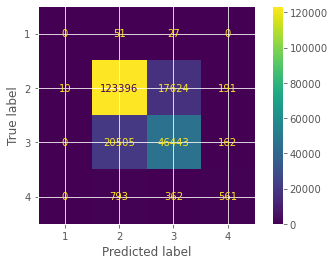

In [71]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                            max_features='auto',
                           random_state=0,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [78]:
#BEST ONE
# Train and fit model VERSION 2 (per GridSearchCV)                                                  
rf = RandomForestClassifier(n_estimators=200,
                            max_features='auto',
                           random_state=0,
                            max_depth=50,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

accuracy = 0.8230767400356931
F1 score: 0.8224205891331103
Recall score: 0.8230767400356931
[[[210039      8]
  [    78      0]]

 [[ 50623  18281]
  [ 18358 122863]]

 [[124425  18590]
  [ 17609  49501]]

 [[208112    297]
  [  1131    585]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        78
           2     0.8705    0.8700    0.8702    141221
           3     0.7270    0.7376    0.7323     67110
           4     0.6633    0.3409    0.4503      1716

    accuracy                         0.8231    210125
   macro avg     0.5652    0.4871    0.5132    210125
weighted avg     0.8226    0.8231    0.8224    210125

Accuray per class: [0.         0.87047979 0.72698301 0.66326531]


In [83]:
rf = RandomForestClassifier(n_estimators=1000,
                            max_features='auto',
                           random_state=0,
                            max_depth=10,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

accuracy = 0.6237192147531231
F1 score: 0.6743320801049595
Recall score: 0.6237192147531231
[[[201145   8902]
  [    64     14]]

 [[ 54511  14393]
  [ 56207  85014]]

 [[111218  31797]
  [ 22487  44623]]

 [[184435  23974]
  [   308   1408]]]
              precision    recall  f1-score   support

           1     0.0016    0.1795    0.0031        78
           2     0.8552    0.6020    0.7066    141221
           3     0.5839    0.6649    0.6218     67110
           4     0.0555    0.8205    0.1039      1716

    accuracy                         0.6237    210125
   macro avg     0.3740    0.5667    0.3589    210125
weighted avg     0.7617    0.6237    0.6743    210125

Accuray per class: [0.00157021 0.8552114  0.58391782 0.05547238]


accuracy = 0.8142676977989292
F1 score: 0.8146953954555045
Recall score: 0.8142676977989292
[[[210046      1]
  [    78      0]]

 [[ 51291  17613]
  [ 20757 120464]]

 [[122204  20811]
  [ 17024  50086]]

 [[207807    602]
  [  1168    548]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        78
           2     0.8817    0.8417    0.8612    141221
           3     0.7036    0.7632    0.7321     67110
           4     0.2683    0.3590    0.3071      1716

    accuracy                         0.8123    210125
   macro avg     0.4634    0.4909    0.4751    210125
weighted avg     0.8195    0.8123    0.8151    210125



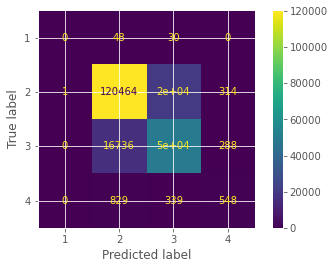

In [72]:
'''
Best Params per GridSearchCV:
{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 200}
'''
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                            bootstrap=True,
                            max_depth=50,
                           max_features='auto',
                            min_samples_leaf=3,
                            min_samples_split=5,
                           random_state=0,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, clf_pred, digits=4))

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [73]:
matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuray per class:', acc_per_class)

Accuray per class: [0.         0.87244074 0.70646149 0.47652174]


In [41]:
# plt.figure(figsize=(20,20))
# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# sns.heatmap(df_bl.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=16)
# plt.show()

## Score improved significantly after resampling:
- Previous RF scores: F1 0.64, Recall 0.63, Accuracy 0.83
- New RF scores: F1 0.889, Recall 0.89, Accuracy: 0.89


- Apparent issue: Year imbalance for Severity 1 accidents...
    - 5436 of 5801 total "Severity 1" accidents were in the year 2020.
    - After resampling, Severity 1 HEAVILY outweighs all other Severity levels in 2020.
    - Because of this, the "Year" column became a very important deciding factor but should it really be?
        - **Solution**: Take out all data from 2020 completely, and only look at 2016 - 2019

### Conclusion so far in the in the initial models before parameter tuning:
- It seems like the impact of "Year" column has decreased after the imbalance in severity distribution in each year was corrected. 
- RF: (Accuracy 0.895 | F1 0.895 | Recall 0.895)


- But were these models performed under the optimal parameters?
    - Run a GridSearchCV to find the optimal parameters
    - Best parameters:
        - {'bootstrap': True,
             'max_depth': 50,
             'max_features': 'auto',
             'min_samples_leaf': 3,
             'min_samples_split': 5,
             'n_estimators': 200}

In [42]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [3, 5, 10, 20, 50, 100],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5, 10],
#     'min_samples_split': [2, 5, 10, 12],
#     'n_estimators': [10, 20, 30, 50, 100, 200]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [43]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [20, 50],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [3, 5],
#     'min_samples_split': [5, 10],
#     'n_estimators': [50, 100]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [44]:
#Undersampling to do gridsearch

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y)

usr = RandomUnderSampler(random_state=462) #this leads to only 11k rows
print('Original dataset shape %s' % Counter(y_train))

X_train, y_train = usr.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({2: 415301, 3: 162873, 4: 5185, 1: 4165})
Resampled dataset shape Counter({1: 4165, 2: 4165, 3: 4165, 4: 4165})


In [45]:
X_train.shape

(16660, 29)

In [74]:
# Parameter Search                                     
model = RandomForestClassifier()

parameters = {'max_depth' : [5,10],
             'min_samples_leaf' : [1, 3],
             'n_estimators': [50, 100],
             'max_features': ['auto']}

scorer = make_scorer(accuracy_score)

clf = GridSearchCV(estimator=model,
                   param_grid=parameters,
                   cv=3,
#                    scoring=scorer,
                  verbose = 10, n_jobs=-1)

clf.fit(X_train,y_train)
# print(f"log loss = {-clf.score(X_test, y_test)}")
# print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")
print(clf.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:  5.9min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  7.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  9.0min remaining:   49.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  9.1min finished


{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
